In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from uav_active_sensing.config import PROCESSED_DATA_DIR
from uav_active_sensing.pytorch_dataloaders import TinyImageNetDataset
from uav_active_sensing.env import ImageEnv
from uav_active_sensing.plots import visualize_tensor

import random as rd
import numpy as np
import collections
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.transforms.functional import resize

from transformers import AutoImageProcessor, ViTMAEForPreTraining


2025-02-03 16:58:08.181 | INFO     | uav_active_sensing.config:<module>:11 - PROJ_ROOT path is: /home/tcouso/uav_active_sensing
/home/tcouso/.virtualenvs/uav_active_sensing/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
cifar10_processed_dir = PROCESSED_DATA_DIR / "cifar10"

cifar10_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

cifar10_train_dataset = datasets.CIFAR10(
    root=cifar10_processed_dir, train=True, download=False, transform=cifar10_transform
)
cifar10_test_dataset = datasets.CIFAR10(
    root=cifar10_processed_dir, train=False, download=False, transform=cifar10_transform
)

cifar10_train_loader = DataLoader(cifar10_train_dataset, batch_size=1, shuffle=True)
cifar10_test_loader = DataLoader(cifar10_test_dataset, batch_size=1, shuffle=False)

In [4]:

TINY_IMAGENET_PROCESSED_DIR = PROCESSED_DATA_DIR / "tiny_imagenet/tiny-imagenet-200"

tiny_imagenet_transform = transforms.Compose([
    # transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

tiny_imagenet_train_dataset = TinyImageNetDataset(
    root_dir=TINY_IMAGENET_PROCESSED_DIR, split="train", transform=tiny_imagenet_transform
)
tiny_imagenet_val_dataset = TinyImageNetDataset(
    root_dir=TINY_IMAGENET_PROCESSED_DIR, split="val", transform=tiny_imagenet_transform
)

tiny_imagenet_train_loader = DataLoader(tiny_imagenet_train_dataset, batch_size=1, shuffle=True)
tiny_imagenet_val_loader = DataLoader(tiny_imagenet_val_dataset, batch_size=1, shuffle=False)

## Reconstruct image with trained autoencoder

In [5]:
image_processor = AutoImageProcessor.from_pretrained("facebook/vit-mae-base", use_fast=True)
pretrained_model = ViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base")

In [6]:
image_processor

ViTImageProcessorFast {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTImageProcessorFast",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [7]:
pretrained_model

ViTMAEForPreTraining(
  (vit): ViTMAEModel(
    (embeddings): ViTMAEEmbeddings(
      (patch_embeddings): ViTMAEPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
    )
    (encoder): ViTMAEEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTMAELayer(
          (attention): ViTMAESdpaAttention(
            (attention): ViTMAESdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTMAESelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTMAEIntermediate(
            (dense): Linear(in_features=768, out_features=

In [8]:
pretrained_model.vit.embeddings.random_masking

<bound method ViTMAEEmbeddings.random_masking of ViTMAEEmbeddings(
  (patch_embeddings): ViTMAEPatchEmbeddings(
    (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
)>

### Inputs

In [9]:
image, _ = tiny_imagenet_train_dataset[15080]
inputs = image_processor(images=image, return_tensors="pt")

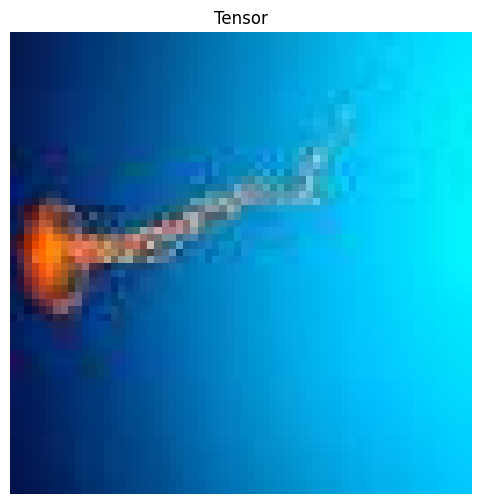

In [10]:
visualize_tensor(transforms.functional.pil_to_tensor(image))

In [11]:
inputs["pixel_values"].squeeze(0).shape

torch.Size([3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


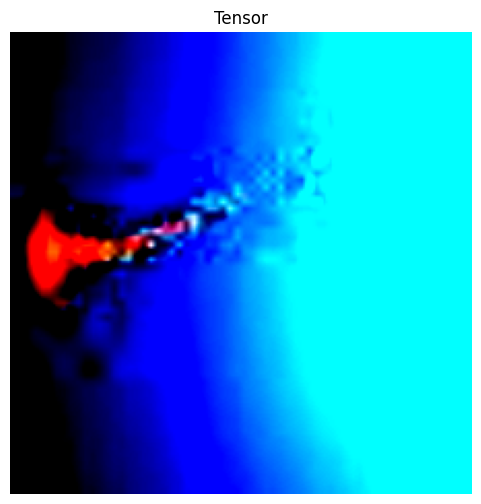

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179044..2.64].


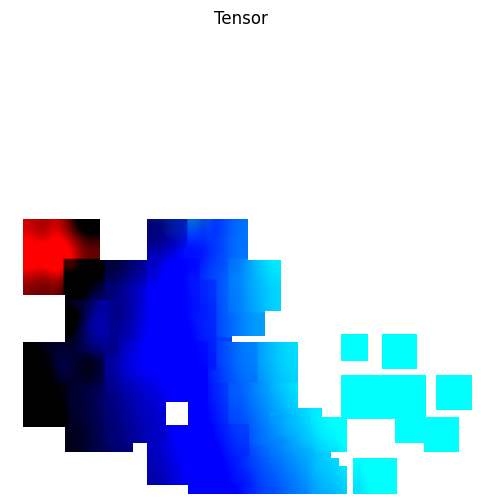

In [55]:
IMG_FOV_RATIO = 16

adapted_inputs = inputs["pixel_values"].squeeze(0)
env = ImageEnv(adapted_inputs, IMG_FOV_RATIO)

env.random_walk(100, planar_step_size=20, altitude_step_size=2)
visualize_tensor(env.img)
visualize_tensor(env.sampled_img)

### Overrinding masking method

In [56]:
def visualize_patches(image, patch_size, mask=None):
    _, ax = plt.subplots()
    ax.imshow(image)

    h, w, _ = image.shape
    num_patches_h = h // patch_size
    num_patches_w = w // patch_size

    # If mask is provided, apply it
    if mask is not None:
        mask = mask.reshape(num_patches_h, num_patches_w)  # Reshape mask to match patch layout
        for i in range(num_patches_h):
            for j in range(num_patches_w):
                if mask[i, j] == 1:  # Masked patch
                    ax.add_patch(plt.Rectangle((j * patch_size, i * patch_size), patch_size, patch_size,
                                               color='gray', linewidth=0))

    # Draw grid lines for patches
    for i in range(0, h, patch_size):
        ax.axhline(i - 0.5, color="black", linewidth=2)
    for j in range(0, w, patch_size):
        ax.axvline(j - 0.5, color="black", linewidth=2)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("Image with Masked Patches")
    plt.show()


In [57]:
def random_masking(sequence, mask_ratio, noise=None):
    """
    Perform per-sample random masking by per-sample shuffling. Per-sample shuffling is done by argsort random
    noise.

    Args:
        sequence (`torch.LongTensor` of shape `(batch_size, sequence_length, dim)`)
        noise (`torch.FloatTensor` of shape `(batch_size, sequence_length)`, *optional*) which is
            mainly used for testing purposes to control randomness and maintain the reproducibility
    """
    batch_size, seq_length, dim = sequence.shape
    len_keep = int(seq_length * (1 - mask_ratio))

    if noise is None:
        noise = torch.rand(batch_size, seq_length, device=sequence.device)  # noise in [0, 1]

    # sort noise for each sample
    ids_shuffle = torch.argsort(noise, dim=1).to(sequence.device)  # ascend: small is keep, large is remove
    ids_restore = torch.argsort(ids_shuffle, dim=1).to(sequence.device)

    # keep the first subset
    ids_keep = ids_shuffle[:, :len_keep]
    sequence_unmasked = torch.gather(sequence, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, dim))

    # generate the binary mask: 0 is keep, 1 is remove
    mask = torch.ones([batch_size, seq_length], device=sequence.device)
    mask[:, :len_keep] = 0
    # unshuffle to get the binary mask
    mask = torch.gather(mask, dim=1, index=ids_restore)

    return sequence_unmasked, mask, ids_restore

In [58]:
processed_sampled_image = env.sampled_img.unsqueeze(0)
processed_image = env.img.unsqueeze(0)

### Standard masking strategy

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


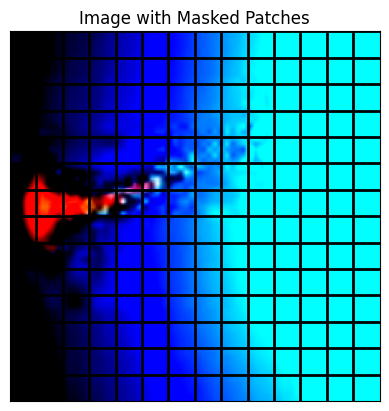

In [59]:
visualize_patches(processed_image.squeeze(0).permute(1, 2, 0), pretrained_model.config.patch_size)

In [60]:
batch_size, num_channels, height, width = processed_image.shape
embeddings = pretrained_model.vit.embeddings.patch_embeddings(processed_image)
position_embeddings = pretrained_model.vit.embeddings.position_embeddings

embeddings = embeddings + position_embeddings[:, 1:, :]

sequence_unmasked, sampled_img_mask, sampled_img_ids_restore = random_masking(embeddings, pretrained_model.config.mask_ratio)

# append cls token
cls_token = pretrained_model.vit.embeddings.cls_token + position_embeddings[:, :1, :]
cls_tokens = cls_token.expand(embeddings.shape[0], -1, -1)
embeddings = torch.cat((cls_tokens, embeddings), dim=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


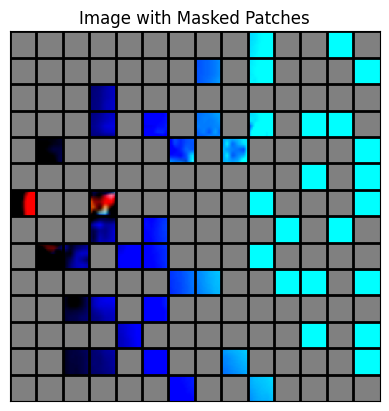

In [61]:
visualize_patches(processed_image.squeeze(0).permute(1, 2, 0), pretrained_model.config.patch_size, mask=sampled_img_mask)

In [62]:
outputs = pretrained_model(processed_image)
loss = outputs.loss
mask = outputs.mask
ids_restore = outputs.ids_restore

In [63]:
outputs

ViTMAEForPreTrainingOutput(loss=tensor(0.0166, grad_fn=<DivBackward0>), logits=tensor([[[-2.0766, -1.5776, -0.4454,  ..., -2.0897, -1.4143, -0.1719],
         [-2.0743, -1.4046, -0.1807,  ..., -2.0896, -1.1927,  0.1043],
         [-2.0798, -1.2069,  0.0890,  ..., -2.0879, -0.9271,  0.3375],
         ...,
         [-2.0608,  1.0443,  2.3694,  ..., -2.1090,  1.0458,  2.2935],
         [-2.0899,  1.1979,  2.4402,  ..., -2.1069,  1.1799,  2.3358],
         [-2.1045,  1.3378,  2.4789,  ..., -2.0759,  1.2575,  2.3385]]],
       grad_fn=<SliceBackward0>), mask=tensor([[1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1.,
         1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1.,
         0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 1., 0., 1.

In [64]:
loss

tensor(0.0166, grad_fn=<DivBackward0>)

In [65]:
mask

tensor([[1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1.,
         1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1.,
         0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1.,
         0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0.,
         1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0.,
         1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1.,
         0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1.,
         1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [66]:
ids_restore

tensor([[173, 115,  88,  57, 184,  20, 125, 162,  97,   7,  72,  24,   9, 133,
         118, 141,   3,  62,  71,  51,  86, 189,  67, 131, 148, 176,  49, 105,
         117, 110, 195,   2,  63,  13,  59, 120,  87, 179, 165, 159, 123,  93,
          12, 104, 147,  52,  39,  54,   1,  19,  89, 172,  84, 170,  22, 150,
          36,  10, 128,  83,  73, 192,  47,  60, 140,   8, 175, 134,  95,  85,
         144,  61, 193,  75,  58, 194, 122,  68, 121,  91, 137, 163,  82, 161,
         153,  70,  17, 181, 157, 156, 142,  18, 151, 126, 177,  30, 188, 155,
          29, 113, 187,  64,  31, 167, 158,  38,  33, 178,   5,  28, 136,  11,
          16,  96, 190,  21, 174,  78,  94, 160, 169,  15,  69, 185, 124,   0,
         183, 116,  66,  27,  98, 127, 135,  50,  65, 112, 132, 186, 171,  40,
          56,  42, 107,  41,  81,  90,  79, 166, 129,   6,  34, 149, 100, 154,
          74, 191, 139,  26,  76, 146,   4,  77,  44, 180,  25,  43, 130, 109,
         164, 143,  32,  14, 101,  80, 111, 103,  23

### Custom masking strategy

In [67]:
def nan_masking(sequence, noise=None):
    """
    Mask patches where any value is NaN.

    Args:
        sequence (`torch.Tensor` of shape `(batch_size, sequence_length, dim)`):
            The patch embeddings.
    
    Returns:
        - `sequence_unmasked` (`torch.Tensor`): Patch embeddings without NaN patches.
        - `mask` (`torch.Tensor`): Binary mask where 1 indicates a masked patch.
        - `ids_restore` (`torch.Tensor`): Indices to restore original order.
    """
    _ = noise
    batch_size, seq_length, dim = sequence.shape

    # Identify patches with NaN values
    nan_mask = torch.isnan(sequence).any(dim=-1)  # Shape: (batch_size, seq_length), True if any NaN in patch

    # Keep only non-NaN patches
    ids_keep = (~nan_mask).nonzero(as_tuple=True)  # Get indices of patches to keep
    sequence_unmasked = sequence.clone()
    sequence_unmasked[nan_mask] = 0  # Replace NaN patches with zero

    # Create a binary mask: 0 for kept patches, 1 for masked patches
    mask = nan_mask.float()

    # Restore indices (identity since we're not shuffling)
    ids_restore = torch.arange(seq_length, device=sequence.device).repeat(batch_size, 1)

    return sequence_unmasked, mask, ids_restore


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179044..2.64].


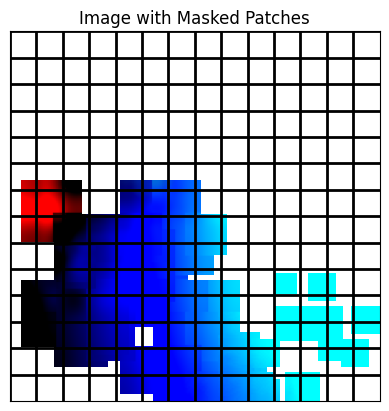

In [68]:
visualize_patches(processed_sampled_image.squeeze(0).permute(1, 2, 0), pretrained_model.config.patch_size)

In [69]:
batch_size, num_channels, height, width = processed_sampled_image.shape
embeddings = pretrained_model.vit.embeddings.patch_embeddings(processed_sampled_image)
position_embeddings = pretrained_model.vit.embeddings.position_embeddings

embeddings = embeddings + position_embeddings[:, 1:, :]

sequence_unmasked, sampled_img_mask, sampled_img_ids_restore = nan_masking(embeddings)

# append cls token
cls_token = pretrained_model.vit.embeddings.cls_token + position_embeddings[:, :1, :]
cls_tokens = cls_token.expand(embeddings.shape[0], -1, -1)
embeddings = torch.cat((cls_tokens, embeddings), dim=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179044..2.64].


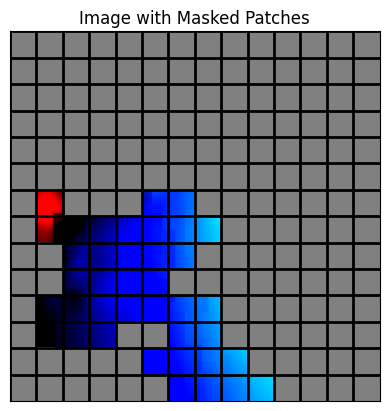

In [70]:
visualize_patches(processed_sampled_image.squeeze(0).permute(1, 2, 0), pretrained_model.config.patch_size, mask=sampled_img_mask)

In [71]:
class CustomMaskViTMAE(ViTMAEForPreTraining):
    def __init__(self, config):
        super().__init__(config)
        # Override the masking method in embeddings
        self.vit.embeddings.random_masking = self.non_sampled_masking

    def non_sampled_masking(self, sequence, noise=None):

        """
        Mask patches that contain a non sampled section, where any value is NaN.

        Args:
            sequence (`torch.Tensor` of shape `(batch_size, sequence_length, dim)`):
                The patch embeddings.
        
        Returns:
            - `sequence_unmasked` (`torch.Tensor`): Patch embeddings without NaN patches.
            - `mask` (`torch.Tensor`): Binary mask where 1 indicates a masked patch.
            - `ids_restore` (`torch.Tensor`): Indices to restore original order.
        """
        _ = noise
        batch_size, seq_length, dim = sequence.shape

        nan_mask = torch.isnan(sequence).any(dim=-1)  # Shape: (batch_size, seq_length), True if any NaN in patch

        sequence_unmasked = sequence.clone()
        sequence_unmasked[nan_mask] = 0  # Replace NaN patches with zero

        # Create a binary mask: 0 for kept patches, 1 for masked patches
        mask = nan_mask.float()

        # Restore indices (identity since we're not shuffling)
        ids_restore = torch.arange(seq_length, device=sequence.device).repeat(batch_size, 1)

        return sequence_unmasked, mask, ids_restore


### External class definition